In [13]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import get_file
import pandas as pd
import numpy as np
import random
from random import randint
import matplotlib.pyplot as plt 
import sys
import io
from keras.utils import plot_model


In [2]:
file = "tweets2020Classified.csv"
data = pd.read_csv(file)
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id_str', 'text', 'created_at',
       'polarity', 'user_location', 'clean_comment', 'stem_comment'],
      dtype='object')

In [4]:
data=data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'id_str', 'clean_comment', 'stem_comment'])
data.head()

,text,created_at,polarity,user_location
0,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,1,"Madrid, Spain"
1,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,1,Albania
2,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,1,"Ross-on-Wye, England"
3,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN
4,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,1,NaN


In [5]:
import re
special_chars = r"[^0-9!@#\$%\^\&\*_\-']"
def Cleaning(tweet,special_chars):
    tweet = re.sub("\d+", "", tweet)
    tweet=re.sub("h[\S]+//[\S]+", "", tweet)
    tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet)
    tweet=tweet.lower()
    for char in special_chars:
        tweet = tweet.replace(char, "")    
    tweet=tweet.split(" ")
    return ' '.join(tweet)
Cleaned=[]
for t in data["text"]:
    Cleaned.append(Cleaning(t,special_chars))
data['text_generation'] = Cleaned
data.head()

,text,created_at,polarity,user_location,text_generation
0,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,1,"Madrid, Spain",rt absolutely remarkable no one who got moder...
1,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,1,Albania,rt the fifth track of the be album was inspi...
2,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,1,"Ross-on-Wye, England",rt dear correct meif i am wrong you have spe...
3,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN,rt deeply moving report on poverty and covid ...
4,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,1,NaN,rt even cnn is now admitting china lied about...


In [7]:
import nltk
tokenizer = nltk.tokenize.TweetTokenizer()
def Lexicon(tokens, Lexico):
    for word in tokens:
        if word in Lexico.keys():
            Lexico[word] += 1
        else:
            Lexico[word] = 1
    return Lexico
lexico={}
for tweet in data["text_generation"]:
    tokens = tokenizer.tokenize(("".join(tweet)))
    lexico.update(Lexicon(tokens,lexico))

In [8]:
len(lexico)

17760

In [9]:
counter=0
val=[]
minlen=1
for v in lexico.values():
    if (v>minlen):
        counter+=1
        val.append(v)

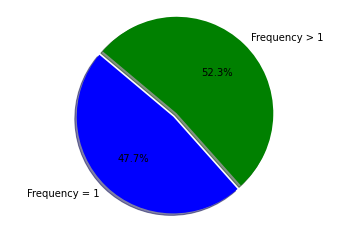

In [14]:
labels = ['Frequency = 1', 'Frequency > 1']
sizes = [len(lexico)-counter,counter]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [22]:
maxlen=400
counter=0
for i in lexico.values():
    if i>=maxlen:
        counter+=1
        
labels = ['> 400 words','<= 400 words']
sizes = [len(totalNumWords),counter]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice
fig.suptitle('Words Distribution', fontsize=20)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

NameError: name 'totalNumWords' is not defined

In [24]:
text=[]
seed=[]
for index in range(len(data)):
    if data.polarity[index]==1:
        text.append(data["text_generation"][index])
    else:
        seed.append(data["text_generation"][index])
        
text=''.join(text)
seed=''.join(seed)

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 4
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1



total chars: 27
nb sequences: 280549
Vectorization...


In [25]:

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(len(chars)/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(seed) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

file_path="generation.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,validation_split=0.1,
          callbacks=[print_callback], use_multiprocessing=True)

model.load_weights(file_path)



file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, callbacks=callbacks_list)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print (model.predict(training_data).round())

model.load_weights(file_path)

Build model...
Train on 252494 samples, validate on 28055 samples
Epoch 1/100
252494/252494 [==============================] - 251s 996us/step - loss: 2.2767 - accuracy: 0.3317 - val_loss: 1.8885 - val_accuracy: 0.4348

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " who were rightly outraged about this is"
 who were rightly outraged about this is to ne the the the the the the the the the thing the the the the the the the the the the the the the the the the the the the the the the the the thig the the the the the the the the the the the the the the the thing the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thing the the the the the the the the gove covid has tou
----- diversity: 0.5
----- Generating with seed: " who were rightly outraged about this is"
 who were rightly outraged about this is covid an as covid candart  ar covid as and cavid covid saced covid  athat ats

OSError: Unable to open file (unable to open file: name = 'generation.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


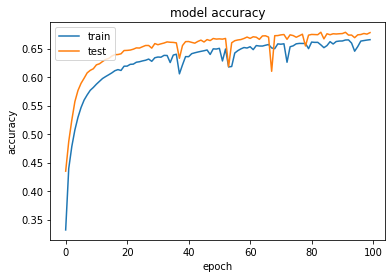

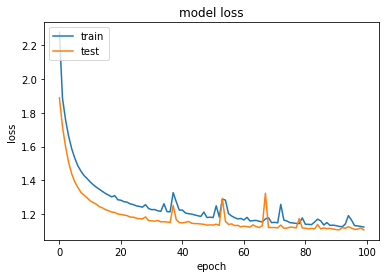

In [27]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
model.save("text_generation.h5")
print("Saved model to disk")

Saved model to disk


In [73]:
from keras.models import load_model
saved_model = load_model("text_generation_weights.h5")
saved_model.get_weights()

[array([[ 0.43399817,  0.59588355, -0.49285123, ..., -0.90425915,
         -0.998771  , -1.3682868 ],
        [ 0.08730642, -4.4009304 , -1.7522186 , ..., -0.502671  ,
         -1.2043085 , -0.46428165],
        [ 2.884622  ,  0.5619513 , -1.5033152 , ..., -2.3360195 ,
          0.01595015, -0.45175236],
        ...,
        [-1.2236202 ,  0.2882771 ,  1.8187007 , ...,  0.7628684 ,
         -1.5646176 ,  0.34257954],
        [-1.1734669 ,  1.0892268 ,  1.7600657 , ..., -0.39055088,
          0.1229129 ,  3.7906325 ],
        [ 6.2549653 , -1.4704711 ,  0.3408857 , ...,  0.309112  ,
          2.1619492 ,  1.7373968 ]], dtype=float32),
 array([[-0.02887894,  1.1695344 , -0.11319676, ...,  1.4162242 ,
         -0.33206454, -0.12542577],
        [-0.9139234 ,  0.13060051,  0.2200678 , ...,  1.1620005 ,
         -2.106777  , -0.27005532],
        [ 0.78049713,  0.99437356,  0.01390389, ...,  0.60997814,
          0.44284034, -0.19886836],
        ...,
        [-0.7366924 ,  0.14308557, -0.6

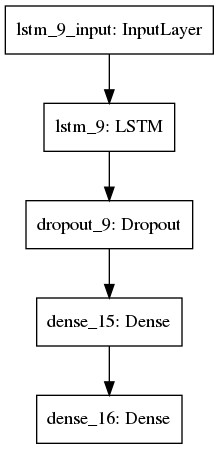

In [70]:
from keras.utils import plot_model
plot_model(saved_model)

In [4]:
saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               79872     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 141)               18189     
_________________________________________________________________
dense_16 (Dense)             (None, 27)                3834      
Total params: 101,895
Trainable params: 101,895
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(saved_model)

In [12]:
maxlen=40
testing_phrase="i want to make from this a seed and that make from this a seed and that"
l = np.zeros((len(testing_phrase), maxlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        l[i, t, char_indices[char]] = 1

y_pred = saved_model.predict(l)
print(y_pred)

NameError: name 'chars' is not defined

In [79]:
y_pred = saved_model.predict(l)
print(y_pred)

[[9.87512410e-01 1.48069070e-04 1.28069123e-05 ... 1.07352264e-07
  2.61014211e-05 2.45205993e-05]
 [9.90005672e-01 5.70789962e-06 6.98001168e-06 ... 4.23198045e-08
  6.99104130e-05 1.15316652e-06]
 [1.90636438e-05 4.80930212e-05 2.56302192e-05 ... 7.38048857e-06
  1.66940208e-05 5.03822366e-06]
 ...
 [3.11318552e-04 2.28518729e-06 2.33456849e-05 ... 4.41551601e-05
  8.34006414e-07 2.74012182e-05]
 [4.75732014e-02 6.61462322e-02 4.51106653e-02 ... 8.06665514e-04
  3.10786124e-02 1.55823887e-03]
 [1.48437932e-04 8.42643567e-05 3.29835302e-06 ... 6.56451448e-06
  7.67405072e-06 1.74163915e-06]]


In [76]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = "this is just a lie of the big companies"
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = saved_model.predict(x_pred, verbose=0)[0]
        next_index = data(preds, diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

----- diversity: 0.2
----- Generating with seed: "this is just a lie of the big companies"
this is just a lie of the big companies

TypeError: 'DataFrame' object is not callable